This is an implementation of an extremely simple NN intended only to predict the contents of a tile given no other information to leverage.

# Import Modules and Run Dependencies

## Data Loaders and Handlers

In [40]:
%run './Loading Dataset and Preprocess.ipynb'
%run './Plotting Tools.ipynb'

In [41]:
import numpy as np
import torch  # pytorch for neural network
from matplotlib import pyplot as plt  # basic plotting

## Modules

# Define Fully Connected Neural Network

## Calculate Piece Probabilities

From the kaggle site:

    100000 images of a randomly generated chess positions of 5-15 pieces (2 kings and 3-13 pawns/pieces)
    Images were generated using 28 styles of chess boards and 32 styles of chess pieces totaling 896 board/piece style combinations.

    Images were generated using this custom-build tool

    All images are 400 by 400 pixels.

        Training set: 80000 images
        Test set: 20000 images

    Pieces were generated with the following probability distribution:

        30% for Pawn
        20% for Bishop
        20% for Knight
        20% for Rook
        10% for Queen

    2 Kings are guaranteed to be on the board.
    
The pieces probabilities (EG 30% for Pawn) can be thought as conditional probabilities of a specific piece appearing on a tile *given* a (non-king) piece appears on that tile:

$$
P\left(\mbox{tile is a pawn}\middle|\mbox{tile is occupied (by a non-king)}\right)
=P\left(T=p \middle| O\right) = .3
$$

A tiles probability of being occupied by a non-king is denoted:
$$
P\left(\mbox{tile is occupied (by a non-king)}\right) = P\left(O\right)
$$
By the law of total probability we have:
$$
P\left(T=p\right) = P\left(T=p \middle| E\right) P\left(O\right)
$$
(as $P\left(T=p\middle | O'\right) = 0$). By symmetry, this is the case for all other pieces (except for king).

Since the king appears twice on the board, we know the probability of a tile being a king is exactly $2/64 = .03125$.

The other 62/64 percent encompasses all other pieces and empty tiles. On average, we expect $8$ other pieces, giving us an expected $54/64$ empty tiles (or $84.375\%$). This leaves us with $P\left(O\right) = .125$, or $12.5\%$

Now, we plug in the conditional probabilities

In [42]:
posterior = {
         'Pawn'   : .3,
         'Bishop' : .2,
         'Night' : .2,  # spelled incorrectly for later use
         'Rook'   : .2,
         'Queen'  : .1,
}
condition = .125
absolute = {p : posterior[p] * condition for p in posterior}
# add a kings probability
absolute['King'] = .03125

# divide by two and add in white and black pieces
colored_absolute = {}
for p in absolute:
    colored_absolute['Black ' + p] = absolute[p] / 2
    colored_absolute['White ' + p] = absolute[p] / 2

# add unoccupied tiles probability
colored_absolute['Unoccupied'] = .84375
print(sum(colored_absolute.values()))
colored_absolute

1.0


{'Black Pawn': 0.01875,
 'White Pawn': 0.01875,
 'Black Bishop': 0.0125,
 'White Bishop': 0.0125,
 'Black Night': 0.0125,
 'White Night': 0.0125,
 'Black Rook': 0.0125,
 'White Rook': 0.0125,
 'Black Queen': 0.00625,
 'White Queen': 0.00625,
 'Black King': 0.015625,
 'White King': 0.015625,
 'Unoccupied': 0.84375}

## Network Architecture

In [43]:
# Currently has 2 hidden layers of size 50

# possible labels: (B, W) X (K,Q,R,N,P,B) + E \in P^{13}
# probability vector of length 13

# CrossEntropyLoss is modified with the expected probability of each outcome.
# These were derived from the data source (instead of balancing the dataset)
class FullyConnectedNN(torch.nn.Module):

    def __init__(self, image_dims, probability_distribution, learning_rate=.1, momentum=0.9):
        super(FullyConnectedNN, self).__init__()
        color = len(image_dims) == 3
        self.model = torch.nn.Sequential(
            torch.nn.Linear(np.product(image_dims), 50),
            torch.nn.Sigmoid(),
            torch.nn.Linear(50, 13)
        )
        self.criterion = torch.nn.CrossEntropyLoss(weight=probability_distribution)
        self.optimizer = torch.optim.SGD(self.parameters(),
                                         lr=learning_rate,
                                         momentum=momentum)

    def forward(self, x):
        return torch.softmax(self.model(x), dim=1)

    def get_loss(self, X, Y):
        out = self.model(X)
        return self.criterion(out, Y)
    
    def predict(self, X):
        probs = torch.nn.Softmax(dim=1)(self.forward(X))
        return torch.argmax(X, dim=1)

In [44]:
def prepare_batch_for_FCNN(batch, label_index):
    """Prepare a batch for the NN"""
    tiles = tileify(*batch)
    X = []
    Y = []
    for tile in tiles:
        X.append(tile.image)
        Y.append(label_index.index(
            tile.piece_color + tile.piece_label))
    return torch.Tensor(X).view(
        -1, np.product(tile_size) * 3).float(), torch.Tensor(Y).long()

# Demonstration

Here, we will demonstrate the usage of this network.

In [45]:
from itertools import repeat
import operator as op

In [46]:
nepochs = 10000
color = True
resize = 80, 80  # desired dimensions for the whole chess board
train_sample_size = 800#00  # sample size for training
test_sample_size = 200#00  # sample size for 
batch_size = 300  # batch size for training

# calculations for parameters into the 

# calculate NN input image size (tile_size)
original_size = 400, 400
tile_size = np.array(resize) // (8, 8)

# possible labels: C = (B, W) X (K,Q,R,N,P,B) + '' \in \left\{0,1\right\}^{13} : \sum_i Y_{j,i} = 1
label_index = [a + b for a in 'WB' for b in 'KQRNPB'] + ['']
index_mapping = {a: ''.join(map(op.itemgetter(0), a.split()))
                 for a in colored_absolute}

# fix unoccupied mapping
index_mapping['Unoccupied'] = ''

# flip unoccupied mapping to be from short to long
index_mapping = {b: a for a, b in index_mapping.items()}

# extract probabilites in correct order
probabilities = list(map(op.getitem,
    repeat(colored_absolute),
    map(op.getitem, repeat(index_mapping), label_index)
))


# create neural network
epoch = 0
network = FullyConnectedNN(
    (*tile_size, 3),
    torch.Tensor(probabilities)
)

# create test and train sets
indexset_train = np.random.choice(80000, size=train_sample_size, replace=False)
indexset_test = np.random.choice(20000, size=test_sample_size, replace=False)

In [47]:
optimizer = network.optimizer

<IPython.core.display.Javascript object>


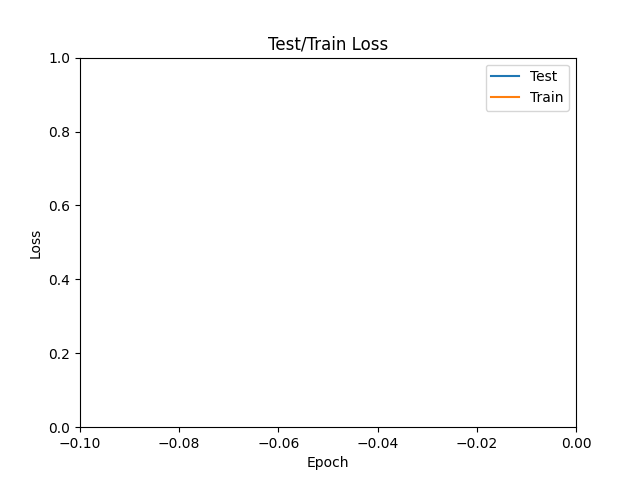

TypeError: object of type 'numpy.int64' has no len()

In [48]:
%matplotlib notebook
# plot the loss on test and train sets
loss_plot = LivePlot(2, labels=['Test', 'Train'],
                     ylab='Loss', xlab='Epoch', title='Test/Train Loss')

# adds nepochs each time it is run (unless network is reset)
for epoch in range(epoch, epoch + nepochs):
    train_loss = 0
    train_n = 0
    for i, (X, Y) in enumerate(
        map(prepare_batch_for_FCNN,
            batched_load(color=color, dsize=resize,
                         batchsize=300, idxset=indexset_train),
            repeat(label_index))):
        
        optimizer.zero_grad()
        loss = network.get_loss(X, Y)
        loss.backward()
        train_loss += loss.item() * len(X)
        train_n += len(X)
        optimizer.step()
    test_loss /= test_n
    for i, (X, Y) in enumerate(
        map(prepare_batch_for_FCNN,
            batched_load(test=True, color=color, dsize=resize,
                         batchsize=300, idxset=indexset_test),
            repeat(label_index))):
        loss = network.get_loss(X, Y)
        test_loss += loss.item() * len(X)
        train_n += len(X)
    train_loss /= train_n
    loss_plot.update((test_loss, train_loss))
        

In [ ]:
np.array(epochs).T[:2]